In [1]:
import numpy as np
import pandas as pd
from util import backrest
import datetime
import talib
import pandas_ta as ta
from tqdm import tqdm
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib notebook

# TS Preprocessing

## Get data

In [2]:
def download_scndry_data(symbol, interval, tf, tt):
    ## Get data
    raw_data = backrest.primary_data(symbol, 200, interval, False, time_from = tf, time_to = tt)

    return raw_data

def string_from_time(dt):
    return dt.strftime("%d") + " " + dt.strftime("%b") + ", " + dt.strftime("%Y") + ", " + dt.strftime("%H:%M:%S")

def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

## Auto Labelling

In [3]:
def loop_signals(data, labelled_signals, signal_time):
    enter_time = signal_time + datetime.timedelta(minutes = 1) # enter on bar after signal
    time_to_check = 120
    for j in range(1,time_to_check): # now loop through prices following signals
        # triple barrier method
        forward_ix = enter_time + datetime.timedelta(minutes = j)
        if j < time_to_check-1:
            if data.loc[forward_ix, "High"] >= data.loc[enter_time, "Open"]*(1+0.03): # top barrier
                #print(f"Enter: {enter_time}")
                #print(f"Forward: {forward_ix}")
                ls = [signal_time, data.loc[signal_time, "Close"], 1]
                return ls
            elif data.loc[forward_ix, "Low"] <= data.loc[enter_time, "Open"]*(1-0.01): # bottom barrier
                ls = [signal_time, data.loc[signal_time, "Close"], 0]
                return ls
            else: # no barriers hit: keep going
                continue
        else: # right barrier
            if data.loc[forward_ix, "Close"] > data.loc[enter_time, "Open"]:
                ls = [signal_time, data.loc[signal_time, "Close"], 1]
            else:
                ls = [signal_time, data.loc[signal_time, "Close"], 0]
            return ls

def auto_labeller(data):
    # inputs:
    # - price dataframe
    # - 
    
    high = data['High'].values
    low = data['Low'].values
    close = data['Close'].values
    copen = data['Open'].values
    vol = data['Volume'].values
    
    short_ema = talib.EMA(vol, 5)
    long_ema = talib.EMA(vol, 10)
    vol_osc = 100*(short_ema - long_ema) / long_ema
    
    rsi = talib.RSI(close, 14)
    cmo = talib.CMO(close)
    
    data['RSI'] = rsi
    data['CMO'] = cmo
    data['vosc'] = vol_osc
    data['pct_change'] = (close - copen)/copen
    
    index = 1
    unfiltered_signals_time = []
    # first create signals
    for i, row in data.iterrows():
        if index > 5:
            backward_ix = i - datetime.timedelta(minutes = 5)
            backward_check_ix = i - datetime.timedelta(minutes = 10)
            price_change = (row['High'] - data.loc[backward_ix, "Close"])/data.loc[backward_ix, "Close"]

            # conditions
            if row["vosc"] > 50 and row["RSI"] > 70 and price_change > 0.01:
                if not unfiltered_signals_time:
                    unfiltered_signals_time.append(i)
                elif not time_in_range(backward_check_ix, i, unfiltered_signals_time[-1]):
                    unfiltered_signals_time.append(i)
                
        index += 1
        
    labelled_signals = []
    for signal_time in unfiltered_signals_time: # first loop through signals
        ls = loop_signals(data, labelled_signals, signal_time)
        labelled_signals.append(ls)
        
    labelled_signals_df = pd.DataFrame(labelled_signals, columns=["Time", "Price", "Signal"])
    return labelled_signals_df

### Visualise signals

In [4]:
def plot_signals(data, signals):
    display(data)
    signal_df = data.join(signals)
    ap1 = mpf.make_addplot(signal_df["Price"], type="scatter", markersize=200, marker = "^", color="green")
    ap2 = mpf.make_addplot(data["RSI"], color="purple", panel = 2)
    
    mpf.plot(data, type="candle", style="charles", volume=True, addplot=[ap1,ap2], warn_too_much_data = 20000)
    #plt.savefig("ctxc_800day_1h_signals", dpi=200)
    plt.show()
    
#plot_signals(data, labelled_data_pos)

                  Time   Price  Signal
0  2022-08-15 10:58:00  0.1492       1
1  2022-08-15 11:46:00  0.1506       1
2  2022-08-16 19:46:00  0.1489       0
3  2022-08-19 10:49:00  0.1500       1
4  2022-08-19 13:41:00  0.1516       0
5  2022-08-19 16:18:00  0.1527       1
6  2022-08-19 18:56:00  0.1521       0
7  2022-08-19 19:56:00  0.1566       1
8  2022-08-20 08:18:00  0.1742       0
9  2022-08-20 08:45:00  0.1850       1
10 2022-08-20 17:39:00  0.1717       0
11 2022-08-21 00:23:00  0.1683       1
12 2022-08-21 17:41:00  0.1737       1
13 2022-08-21 18:02:00  0.1747       1
14 2022-08-21 20:28:00  0.1824       1
15 2022-08-22 00:07:00  0.2030       0
16 2022-08-22 07:04:00  0.2066       1
17 2022-08-22 08:28:00  0.2066       1
18 2022-08-22 17:30:00  0.1969       1
19 2022-08-22 19:02:00  0.2031       1
20 2022-08-22 23:31:00  0.1981       1
21 2022-08-23 00:59:00  0.2250       0
22 2022-08-23 03:04:00  0.2205       0
23 2022-08-23 04:08:00  0.2208       1
24 2022-08-23 04:49:00  0

,Open,High,Low,Close,Volume,RSI,CMO,vosc,pct_change
Time,,,,,,,,,
2022-08-15 08:17:00,0.1495,0.1495,0.1492,0.1492,4364.0,NaN,NaN,NaN,-0.002007
2022-08-15 08:18:00,0.1493,0.1493,0.1492,0.1492,14696.0,NaN,NaN,NaN,-0.000670
2022-08-15 08:19:00,0.1492,0.1493,0.1491,0.1493,5399.0,NaN,NaN,NaN,0.000670
2022-08-15 08:20:00,0.1493,0.1495,0.1493,0.1495,50550.0,NaN,NaN,NaN,0.001340
2022-08-15 08:21:00,0.1496,0.1497,0.1496,0.1497,561.0,NaN,NaN,NaN,0.000668
...,...,...,...,...,...,...,...,...,...
2022-08-25 08:11:00,0.2317,0.2317,0.2317,0.2317,1744.0,47.399395,-5.201210,-2.165986,0.000000
2022-08-25 08:12:00,0.2315,0.2315,0.2315,0.2315,487.0,39.917556,-20.164887,-5.863939,0.000000
2022-08-25 08:13:00,0.2315,0.2315,0.2315,0.2315,118.0,39.917556,-20.164887,-19.076061,0.000000


<IPython.core.display.Javascript object>


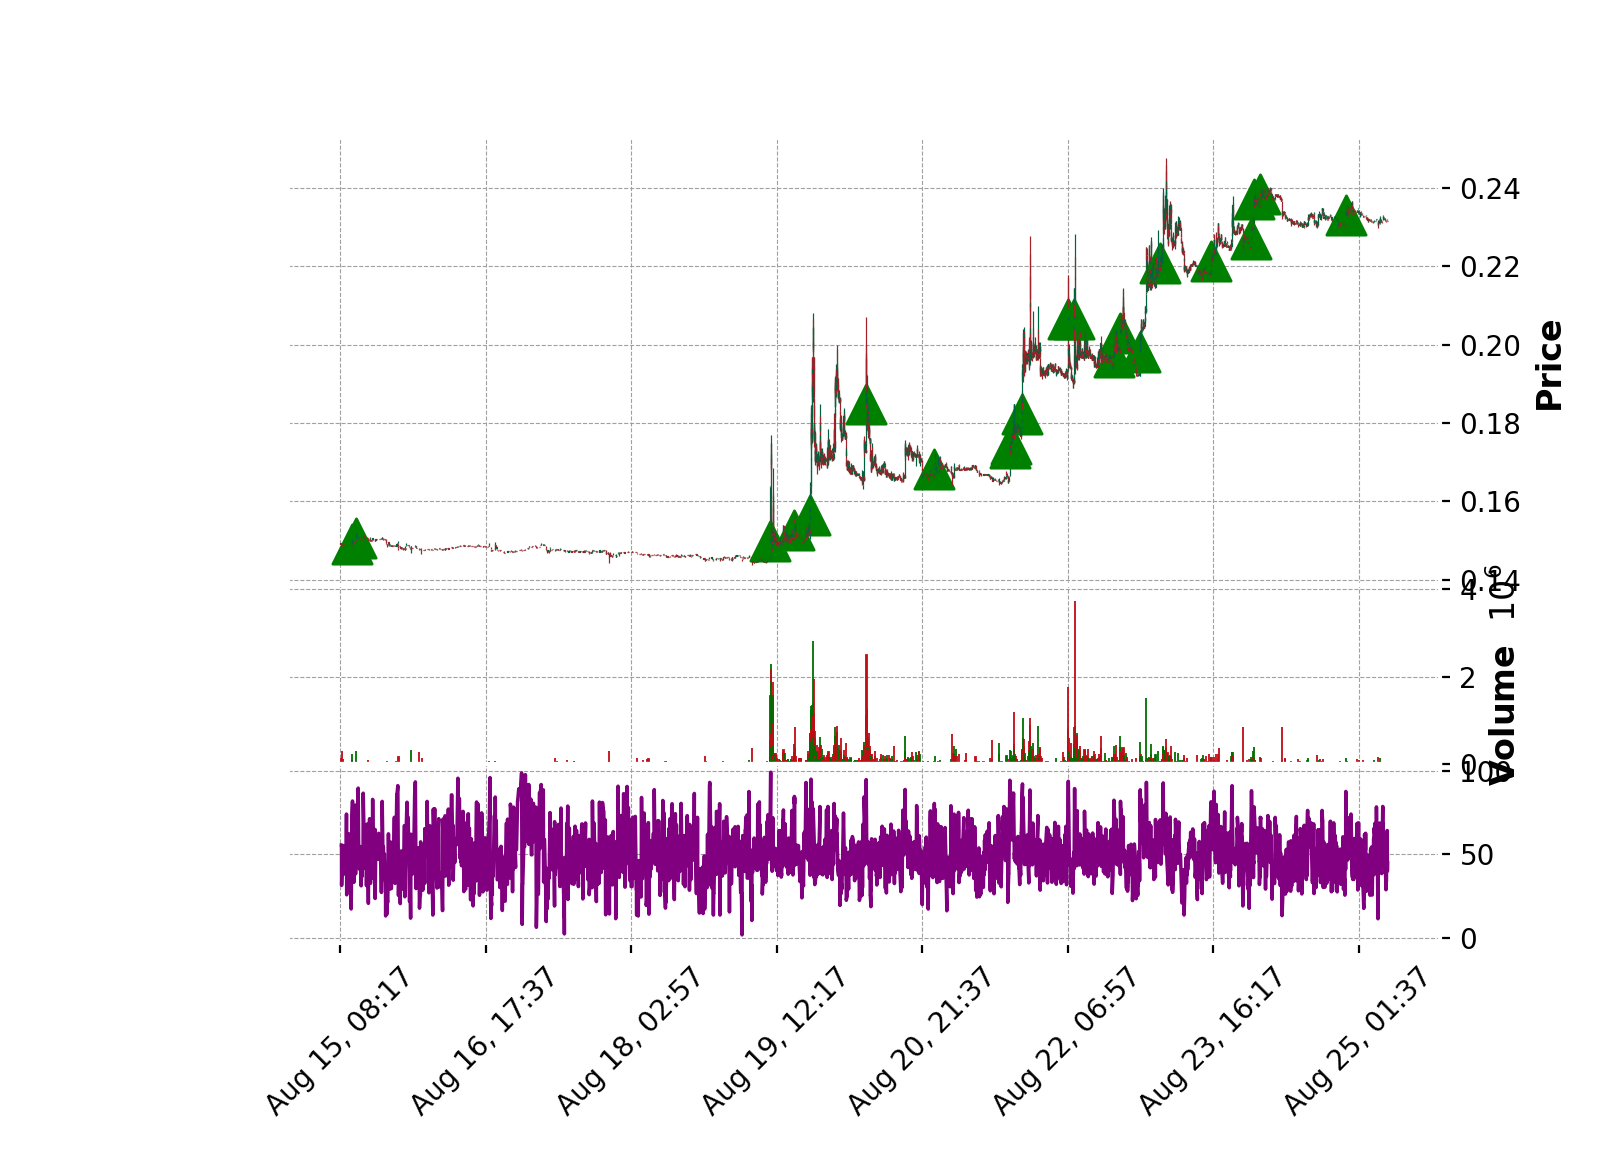

In [5]:
# DCR, SCRT, ALCX, ROSE, FLOW, GRT, XVS, RIF
# DCR doesn't work

def visualise_signals():
    raw_data = backrest.primary_data("TRIBEUSDT", 10, "1m", False)
    data = raw_data.copy(deep=True)
    labelled_data = auto_labeller(data)
    
    labelled_data_pos = labelled_data[labelled_data["Signal"] == 1]
    labelled_data_pos.set_index("Time", inplace=True)
    print(labelled_data)
    
    plot_signals(data, labelled_data_pos)
    
visualise_signals()

## Candle pockets

In [209]:
#symbols = ["CTXCUSDT", "ANTUSDT", "COCOSUSDT", "IOTXUSDT", "ANTUSDT", "PNTUSDT", \
#           "GTOUSDT", "PERLUSDT", "DENTUSDT", "CHRUSDT", "CKBUSDT", "POWRUSDT", \
#           "ELFUSDT", "ARDRUSDT", "POLYUSDT", "CHESSUSDT", "GTCUSDT", "STPTUSDT", \
#           "PONDUSDT", "DCRUSDT"]
#pocket_tf = "5m"

#symbols = ["LAZIO", "SANTOS", "KNC", "TRIBE", "IDEX", "UMA", \
#           "CHZ", "TVK", "HIVE", "TRB", "DIA", "DCR", "SCRT", \
#           "ALCX", "ROSE", "FLOW", "GRT", "XVS", "RIF", "EOS", \
#           "ALPINE", "PORTO", "UNFI", "AVA", "RLC", "CHR"]
    
#symbols = ["ALCX", "ROSE", "FLOW", "GRT", "XVS", "RIF", "EOS"]

symbols = ["ROSE", "FLUX", "TRIBE", "HIVE", "UNFI", "IDEX", "CHR", \
           "CHZ", "BNT", "DCR", "KAVA"]
symbols = [x + "USDT" for x in symbols]

def get_candle_pockets(symbols, pocket_tf, window_length = 200, get_returns = True):
    labelled_datas = [] # list of dataframes of labelled data for each symbol
    candle_pocket_rtrns_list = [] # list of dataframes of candle pockets for each symbol
    candle_pocket_prices_list = []
    empty_ixs = []
    for symbol in tqdm(symbols):
        try:
            raw_data = backrest.primary_data(symbol, 100, "1m", False) # 10 days ago
            data = raw_data.copy(deep=True)
            labelled_data = auto_labeller(data)
            #print(labelled_data)
            labelled_datas.append(labelled_data)
        except (KeyError, IndexError) as e:
            print(f"Error occurred, skipping symbol {symbol}...")
            continue
        
        signals = labelled_data["Signal"]
        empt_ix = []

        for i, row in labelled_data.iterrows():
            pocket_tf_time = int(''.join(filter(str.isdigit, pocket_tf)))
            pocket_tf_interval = str(''.join(filter(str.isalpha, pocket_tf)))

            if pocket_tf_interval == "m":
                time_diff = datetime.timedelta(minutes = window_length*pocket_tf_time)
                time_from = row["Time"] - time_diff
                #time_to = row["Time"] + datetime.timedelta(hours=1) # should be minutes?
                time_to = row["Time"]
            elif pocket_tf_interval == "H":
                time_diff = datetime.timedelta(hours = window_length*pocket_tf_time)
                time_from = row["Time"] - time_diff
                time_to = row["Time"] + datetime.timedelta(hours=1)
                
            #time_from = row["Time"] - time_diff
            #time_to = row["Time"]# + datetime.timedelta(hours=1)

            time_from_str = string_from_time(time_from)
            time_to_str = string_from_time(time_to)
            
            candle_pocket_prices = download_scndry_data(symbol, interval = pocket_tf, tf = time_from_str, tt = time_to_str)
        
            if candle_pocket_prices.empty:
                empt_ix.append(i)
                print("empty candle pocket")
                continue # go to next iteration if we get an empty dataframe
            else:
                if get_returns:
                    candle_pocket_rtrns = candle_pocket_prices.copy(deep=True)

                    #for typ in ["Open", "High", "Low", "Close", "Volume"]: # get log returns for each column
                     #   candle_pocket_rtrns[typ] = ffd.frac_diff_ffd(candle_pocket_rtrns[typ].apply(np.log), d=0.7, thres=5e-5)
                    candle_pocket_rtrns = np.log(candle_pocket_rtrns) - np.log(candle_pocket_rtrns.shift(1))
                    candle_pocket_rtrns = candle_pocket_rtrns.iloc[1:]

                    #candle_pocket_rtrns = ffd_fixed.get_fdf(candle_pocket_rtrns, d = 0.5, thresh = 1e-3)
                    #print(candle_pocket_rtrns)
                    
                    #candle_pocket_rtrns = candle_pocket_rtrns.iloc[150:]
                    candle_pocket_rtrns['id'] = id_ix
                    candle_pocket_rtrns['signal'] = row['Signal']
                    
                    ## indicators
                    indi_df = backrest.get_indicators(candle_pocket_prices)
                    candle_pocket_rtrns = candle_pocket_rtrns.join(indi_df)
                    candle_pocket_rtrns = candle_pocket_rtrns.tail(1) # get last row
                    #candle_pocket_rtrns['ADX'] = candle_pocket_prices.copy().ta.uo()
                    #candle_pocket_rtrns['ADX_c'] = candle_pocket_rtrns['ADX'].pct_change()
                    
                    candle_pocket_rtrns.reset_index(inplace=True)
                    candle_pocket_rtrns.reset_index(inplace=True)
                    candle_pocket_rtrns_list.append(candle_pocket_rtrns)
                    
                    ## not needed
                    candle_pocket_prices['signal'] = row['Signal']
                    candle_pocket_prices.reset_index(inplace=True)
                    candle_pocket_prices.reset_index(inplace=True)
                    candle_pocket_prices_list.append(candle_pocket_prices)
                    ## not needed
                else:
                    candle_pocket_prices['id'] = id_ix
                    candle_pocket_prices['signal'] = row['Signal']
                    #candle_pocket_prices['Symbol'] = symbol
                    candle_pocket_prices_list.append(candle_pocket_prices)

                id_ix += 1
                
        empty_ixs.append(empt_ix)
    
    if get_returns:
        all_return_pockets = pd.concat(candle_pocket_rtrns_list, axis='index')
        all_prices_pockets = pd.concat(candle_pocket_prices_list, axis='index')
        return [all_return_pockets, all_prices_pockets], labelled_datas, empty_ixs
    else:
        all_prices_pockets = pd.concat(candle_pocket_prices_list, axis='index')
        return all_prices_pockets, labelled_datas, empty_ixs

In [210]:
import warnings
warnings.filterwarnings('ignore')

all_pockets, labelled_datas, y_to_drop = get_candle_pockets(symbols, "1m", window_length=100, get_returns=True)
all_labels = pd.concat(labelled_datas, axis='index')
y_to_drop

 18%|█▊        | 2/11 [03:24<16:45, 111.74s/it]

 36%|███▋      | 4/11 [06:26<11:33, 99.12s/it] 

 45%|████▌     | 5/11 [08:45<11:22, 113.70s/it]

 55%|█████▍    | 6/11 [10:52<09:49, 117.95s/it]

 64%|██████▎   | 7/11 [15:03<10:45, 161.45s/it]

 73%|███████▎  | 8/11 [16:37<07:00, 140.15s/it]

 82%|████████▏ | 9/11 [18:46<04:33, 136.69s/it]

 91%|█████████ | 10/11 [22:33<02:44, 164.59s/it]

100%|██████████| 11/11 [28:11<00:00, 153.75s/it]


[[], [], [], [], [], [], [], [], [], [], []]

In [211]:
return_data = all_pockets[0]
price_data = all_pockets[1]
return_data

,index,Time,Open,High,Low,Close,Volume,id,signal,alma,...,pvol,pvr,pvt,atr,massi,natr,pdist,rvi,true_range,ui
0,0,2022-05-15 19:13:00,-0.002783,-0.002916,-0.002392,-0.001992,-0.161553,1,1,-0.004518,...,3164.723985,4.0,91945.966159,-0.004684,24.483757,-0.002699,-1.776357e-12,47.429566,-0.090909,0.452017
1,1,2022-05-15 19:14:00,-0.001860,-0.000531,0.000532,0.000665,-1.548029,1,1,-0.004341,...,673.479162,2.0,92540.880399,-0.037899,24.382795,-0.038538,-4.000000e-01,54.452771,-0.500000,0.477759
2,2,2022-05-15 19:15:00,0.000665,-0.000664,-0.000931,-0.001729,0.523471,1,1,-0.005708,...,1134.786059,3.0,89931.846384,-0.026123,24.330734,-0.024438,-1.333333e-01,46.622868,0.300000,0.508195
3,3,2022-05-15 19:16:00,-0.001197,0.000930,0.000399,0.002526,0.956594,1,1,-0.002171,...,2961.107884,1.0,99874.083839,-0.003437,24.325303,-0.005951,4.615385e-01,54.268570,0.461538,0.520281
4,4,2022-05-15 19:17:00,0.002127,0.002122,0.002127,0.002122,0.739657,1,1,0.001146,...,6217.340436,1.0,117371.842734,-0.013975,24.289885,-0.016065,-1.578947e-01,60.764288,-0.157895,0.514783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,55,2022-08-27 22:33:00,-0.000612,-0.001223,0.000000,0.000000,-inf,1950,0,-0.001179,...,0.000000,2.0,507.366562,-0.071429,26.954068,-0.071429,-1.000000e+00,25.311838,-1.000000,0.322919
56,56,2022-08-27 22:34:00,0.001223,0.001223,0.001223,0.001223,inf,1950,0,-0.001477,...,913.051600,1.0,575.677456,0.022936,27.261421,0.021685,4.503600e+12,41.609349,inf,0.336121
57,57,2022-08-27 22:35:00,0.000611,0.000611,0.000611,0.000611,-1.857481,1950,0,-0.002075,...,142.582700,2.0,581.001417,-0.025304,27.499438,-0.025900,-5.000000e-01,53.211370,-0.500000,0.343858
58,58,2022-08-27 22:36:00,0.001221,0.001221,0.001221,0.001221,-2.412933,1950,0,-0.000921,...,12.784200,2.0,581.954380,0.023215,27.375526,0.021966,1.000000e+00,61.586137,1.000000,0.335971


In [212]:
def clean_data(df):
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    return df

In [213]:
price_data_clean = clean_data(price_data)
return_data_clean = clean_data(return_data)

In [214]:
return_data_clean.head(50)

,index,Time,Open,High,Low,Close,Volume,id,signal,alma,...,pvol,pvr,pvt,atr,massi,natr,pdist,rvi,true_range,ui
0,0,2022-05-15 19:13:00,-0.002783,-0.002916,-0.002392,-0.001992,-0.161553,1,1,-0.004518,...,3164.723985,4.0,9.194597e+04,-0.004684,24.483757,-0.002699,-1.776357e-12,47.429566,-0.090909,0.452017
1,1,2022-05-15 19:14:00,-0.001860,-0.000531,0.000532,0.000665,-1.548029,1,1,-0.004341,...,673.479162,2.0,9.254088e+04,-0.037899,24.382795,-0.038538,-4.000000e-01,54.452771,-0.500000,0.477759
2,2,2022-05-15 19:15:00,0.000665,-0.000664,-0.000931,-0.001729,0.523471,1,1,-0.005708,...,1134.786059,3.0,8.993185e+04,-0.026123,24.330734,-0.024438,-1.333333e-01,46.622868,0.300000,0.508195
3,3,2022-05-15 19:16:00,-0.001197,0.000930,0.000399,0.002526,0.956594,1,1,-0.002171,...,2961.107884,1.0,9.987408e+04,-0.003437,24.325303,-0.005951,4.615385e-01,54.268570,0.461538,0.520281
4,4,2022-05-15 19:17:00,0.002127,0.002122,0.002127,0.002122,0.739657,1,1,0.001146,...,6217.340436,1.0,1.173718e+05,-0.013975,24.289885,-0.016065,-1.578947e-01,60.764288,-0.157895,0.514783
5,5,2022-05-15 19:18:00,0.001990,0.000397,0.001459,-0.000132,-0.802945,1,1,0.001473,...,2785.046769,4.0,1.168829e+05,-0.042295,24.261844,-0.042168,6.250000e-02,52.179898,-0.500000,0.514763
6,6,2022-05-15 19:19:00,0.000397,0.003965,0.000928,0.003835,0.863745,1,1,0.005303,...,6631.590992,1.0,1.505187e+05,0.057859,24.306293,0.053809,1.294118e+00,59.567584,3.250000,0.509909
7,7,2022-05-15 19:20:00,0.003174,0.000264,0.003042,-0.000264,-0.717320,1,1,0.005516,...,3235.749132,4.0,1.493909e+05,-0.035483,24.358520,-0.035228,-4.358974e-01,50.100786,-0.705882,0.508796
8,8,2022-05-15 19:21:00,-0.000396,0.006048,-0.001057,0.003295,2.612385,1,1,0.009750,...,44253.779568,1.0,3.416153e+05,0.167088,24.710464,0.163249,3.681818e+00,58.784758,5.400000,0.508796
9,9,2022-05-15 19:22:00,0.003823,-0.003809,0.001585,-0.000527,-0.626872,1,1,0.009266,...,23630.589325,4.0,3.252377e+05,0.002017,24.978037,0.002544,-5.922330e-01,47.916613,-0.640625,0.505015


In [215]:
for i, rtd in enumerate(y_to_drop):
    labelled_datas[i].drop(rtd, axis='index', inplace=True)
    
y = pd.concat(labelled_datas, axis='index')
y = y.reset_index()
y = y.reset_index()
y.index+=1
y = y["Signal"]

### Indicators

In [216]:
y

1       1
2       0
3       1
4       0
5       0
       ..
1946    0
1947    0
1948    0
1949    0
1950    0
Name: Signal, Length: 1950, dtype: int64

In [217]:
sum(y)/len(y)

0.29128205128205126

## TSFresh

In [218]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

close_diff_data = return_data_clean.drop(["Time", "signal"], axis=1)
extracted_features = extract_features(close_diff_data, column_id="id", column_sort="index", impute_function=impute)

Feature Extraction: 100%|██████████| 30/30 [47:26<00:00, 94.90s/it]  


In [219]:
extracted_features = extracted_features.dropna(axis='columns')

In [220]:
extracted_features

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,ui__permutation_entropy__dimension_5__tau_1,ui__permutation_entropy__dimension_6__tau_1,ui__permutation_entropy__dimension_7__tau_1,ui__query_similarity_count__query_None__threshold_0.0,"ui__matrix_profile__feature_""min""__threshold_0.98","ui__matrix_profile__feature_""max""__threshold_0.98","ui__matrix_profile__feature_""mean""__threshold_0.98","ui__matrix_profile__feature_""median""__threshold_0.98","ui__matrix_profile__feature_""25""__threshold_0.98","ui__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,0.0,0.0,0.0,0.046171,0.000533,0.003086,0.000116,0.000019,0.001283,...,2.645728,2.988273,3.258154,0.0,0.804078,4.313287,1.632954,1.415332,0.916528,2.177228
2,0.0,0.0,0.0,0.0,0.014990,0.000336,0.002736,0.000033,0.000072,0.000416,...,2.607062,2.964400,3.217464,0.0,0.747879,2.530148,1.280099,1.150737,0.869685,1.629829
3,0.0,0.0,0.0,1.0,0.001663,0.000131,0.001668,0.000041,0.000020,-0.000128,...,1.691599,1.972036,2.204019,0.0,1.457982,7.459699,4.892229,5.402778,3.746172,6.020771
4,0.0,0.0,0.0,1.0,0.028848,0.000181,0.001721,0.000007,-0.000044,0.000754,...,1.785629,2.107976,2.402542,0.0,0.862700,5.792458,2.145008,1.762716,1.219897,2.484511
5,0.0,0.0,0.0,1.0,-0.028601,0.000856,0.004289,-0.000033,0.000021,-0.000666,...,1.937489,2.263607,2.576328,0.0,1.163363,7.970859,3.084385,1.968663,1.549834,3.714227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,0.0,0.0,0.0,1.0,0.013725,0.000085,0.001241,-0.000028,0.000005,0.000000,...,2.433314,2.892447,3.234113,0.0,0.888324,4.242389,1.651010,1.454359,1.083885,2.024953
1947,0.0,0.0,0.0,1.0,0.004840,0.000052,0.000875,0.000018,0.000032,0.000000,...,2.735461,3.092592,3.398023,0.0,1.104049,4.129858,1.951164,1.785613,1.543190,2.146210
1948,0.0,0.0,0.0,1.0,0.014505,0.000038,0.000948,0.000018,-0.000005,0.000000,...,2.787318,3.152517,3.407713,0.0,1.143195,8.112202,4.949876,5.209972,2.919540,6.915711
1949,0.0,0.0,0.0,1.0,0.007297,0.000047,0.001029,0.000000,-0.000010,0.000000,...,2.323145,2.765889,3.130757,0.0,1.000070,5.053935,2.326758,1.950732,1.424612,3.160704


In [223]:
## feature selection
features_filtered = select_features(extracted_features, y, fdr_level=0.95)

In [224]:
features_filtered

""
1
2
3
4
5
...
1946
1947
1948
1949


In [179]:
import tsfresh

filtered_features_names = tsfresh.feature_extraction.settings.from_columns(features_filtered)
filtered_features_names

{'decay': {'change_quantiles': [{'f_agg': 'mean',
    'isabs': True,
    'qh': 0.8,
    'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4},
   {'f_agg': 'var

Dump extracted/selected features

In [162]:
## dict 2 good
with open('extracted_features_dict_6', 'wb') as fp:
    pickle.dump(filtered_features_names, fp)

In [198]:
## 4 good
with open('extracted_features_8', 'wb') as fp:
    pickle.dump(extracted_features, fp)

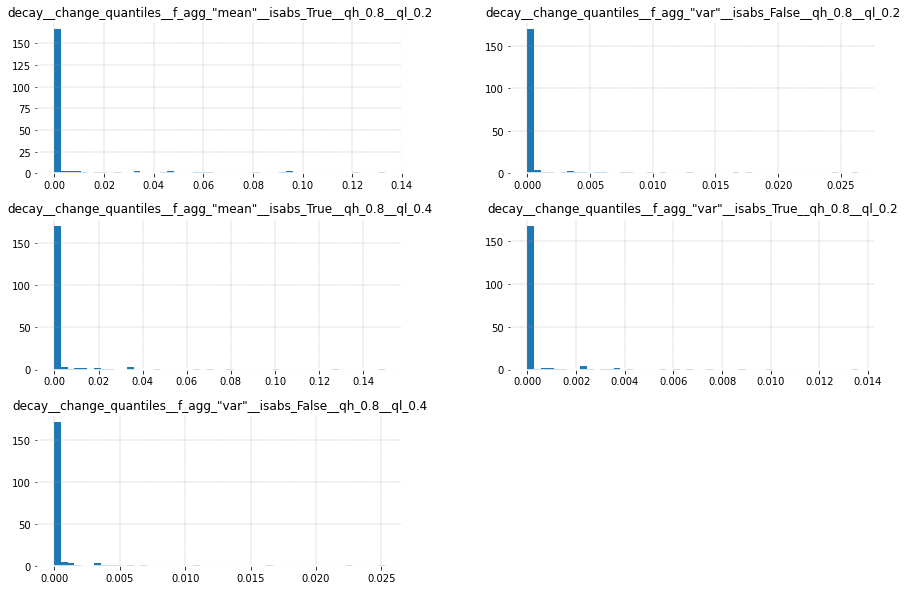

In [164]:
features_filtered_short = features_filtered.iloc[:,0:5]
#features_filtered_short
%matplotlib inline
features_filtered_short.hist(bins=50, figsize=(15,10))
plt.show()

#### Transformation
Data seems to be positively skewed (i.e exponential distribution) so try to take a log transform

In [165]:
ln_features_filtered = np.log(features_filtered)
ln_features_filtered.fillna(0)
ln_features_filtered.replace([np.inf, -np.inf], 0, inplace=True)
ln_features_filtered.columns = ln_features_filtered.columns.str.replace('"', "")
ln_features_filtered

,decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.4,decay__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.4,slope__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.4,bias__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0,decay__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.4,slope__quantile__q_0.1,ema_25__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0,...,dpo__abs_energy,dpo__root_mean_square,pwma__change_quantiles__f_agg_mean__isabs_True__qh_0.4__ql_0.0,pvt__change_quantiles__f_agg_mean__isabs_False__qh_0.6__ql_0.4,pwma__mean_abs_change,kama__change_quantiles__f_agg_var__isabs_True__qh_0.4__ql_0.0,pwma__absolute_sum_of_changes,variance__agg_linear_trend__attr_intercept__chunk_len_10__f_agg_mean,pwma__change_quantiles__f_agg_mean__isabs_True__qh_1.0__ql_0.0,"variance__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)"
1,-10.066006,-19.702865,-10.750785,-20.434022,-21.200644,-21.193269,-14.125490,-22.273280,NaN,-14.215771,...,-14.193504,-8.594618,-7.059967,NaN,-6.962853,-13.707831,-4.018414,-19.217664,-6.962853,-18.426405
2,-9.232813,-18.186048,-9.458802,-19.582746,-18.976504,-21.639557,-12.530591,-20.631599,NaN,-12.821174,...,-12.123455,-7.559594,-6.197369,8.326215,-6.404987,-14.017679,-3.460548,-17.205937,-6.404987,-16.466785
3,-9.881509,-19.587493,-10.231992,-20.629079,-20.488985,-20.325236,-13.816815,-22.219375,NaN,-14.139281,...,-14.346066,-8.670899,-7.098508,7.732748,-6.935562,-15.591683,-3.991123,-18.053029,-6.935562,-17.253720
4,-9.758906,-19.190256,-10.414313,-20.374524,-20.774559,-79.018779,-14.175346,-20.774559,NaN,-14.146498,...,-12.617605,-7.806669,-7.196146,6.688154,-6.545637,-14.880483,-3.601198,-17.416880,-6.545637,-16.637144
5,-9.649707,-19.171248,-10.031321,-20.385031,-20.190287,-24.412145,-13.451137,-20.661230,NaN,-13.494608,...,-12.792894,-7.894313,-6.764981,NaN,-6.739995,-15.229708,-3.795556,-17.141523,-6.739995,-16.373224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-10.066006,-19.702865,-10.750785,-20.434022,-21.200644,-21.193269,-14.125490,-22.273280,NaN,-14.215771,...,-14.193504,-8.594618,-7.059967,NaN,-6.962853,-13.707831,-4.018414,-19.217664,-6.962853,-18.426405
189,-9.232813,-18.186048,-9.458802,-19.582746,-18.976504,-21.639557,-12.530591,-20.631599,NaN,-12.821174,...,-12.123455,-7.559594,-6.197369,8.326215,-6.404987,-14.017679,-3.460548,-17.205937,-6.404987,-16.466785
190,-9.881509,-19.587493,-10.231992,-20.629079,-20.488985,-20.325236,-13.816815,-22.219375,NaN,-14.139281,...,-14.346066,-8.670899,-7.098508,7.732748,-6.935562,-15.591683,-3.991123,-18.053029,-6.935562,-17.253720
191,-9.758906,-19.190256,-10.414313,-20.374524,-20.774559,-79.018779,-14.175346,-20.774559,NaN,-14.146498,...,-12.617605,-7.806669,-7.196146,6.688154,-6.545637,-14.880483,-3.601198,-17.416880,-6.545637,-16.637144


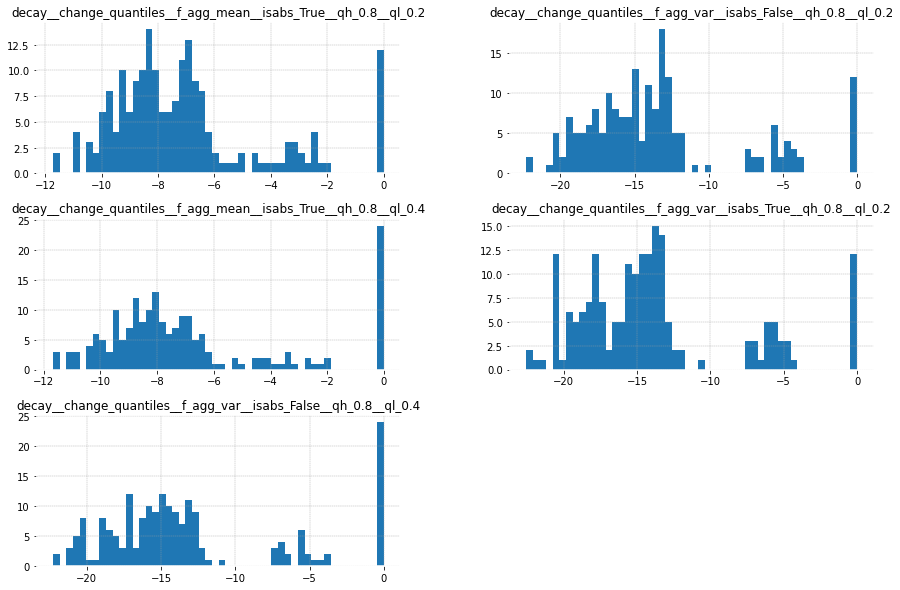

In [166]:
features_filtered_short = ln_features_filtered.iloc[:,0:5]
features_filtered_short.hist(bins=50, figsize = (15,10))
plt.show()

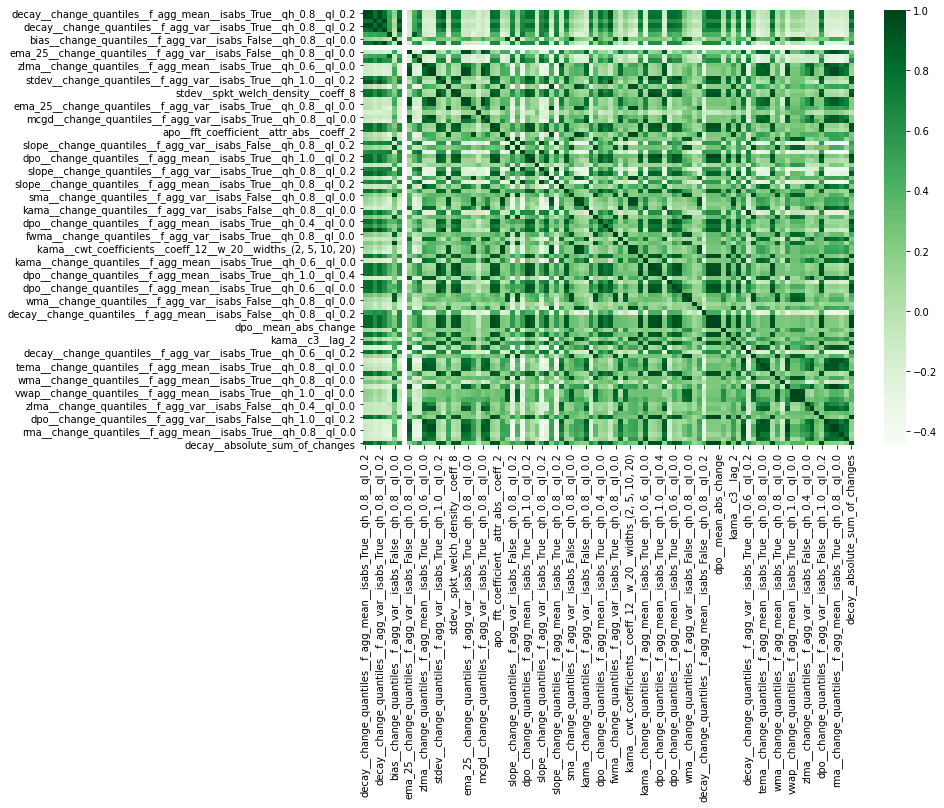

In [170]:
features_filtered_short = ln_features_filtered.iloc[:,0:100]
corr = features_filtered_short.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=False)
plt.show()

[]

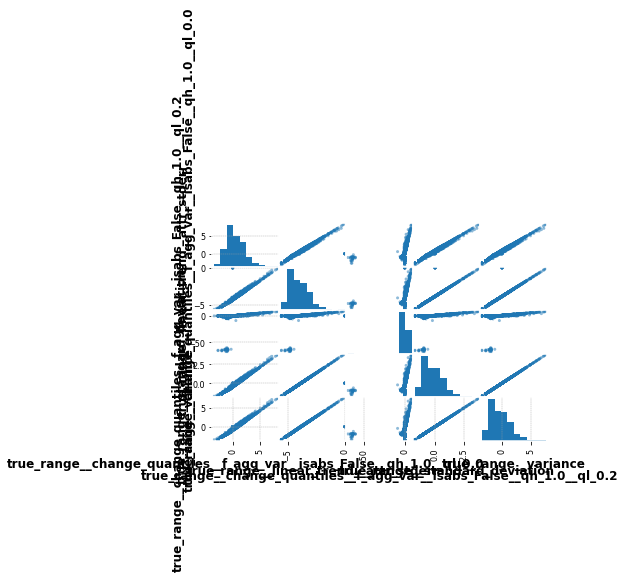

In [43]:
pd.plotting.scatter_matrix(ln_features_filtered.iloc[:,5:10])
plt.plot()

In [44]:
plt.hist(train_data[train_data['signal']==0].kama__friedrich_coefficients__coeff_1__m_3__r_30	, bins = 25, label ='False', alpha = .50,edgecolor= 'black',color ='grey')
plt.hist(train_data[train_data['signal']==1].kama__friedrich_coefficients__coeff_1__m_3__r_30	, bins = 25, label = 'True', alpha = .50, edgecolor = 'black',color = 'lightgreen')

NameError: name 'train_data' is not defined

In [168]:
train_data = ln_features_filtered
train_data["signal"] = y
train_data

,decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.4,decay__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.2,decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.4,slope__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.4,bias__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0,decay__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.4,slope__quantile__q_0.1,ema_25__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0,...,dpo__root_mean_square,pwma__change_quantiles__f_agg_mean__isabs_True__qh_0.4__ql_0.0,pvt__change_quantiles__f_agg_mean__isabs_False__qh_0.6__ql_0.4,pwma__mean_abs_change,kama__change_quantiles__f_agg_var__isabs_True__qh_0.4__ql_0.0,pwma__absolute_sum_of_changes,variance__agg_linear_trend__attr_intercept__chunk_len_10__f_agg_mean,pwma__change_quantiles__f_agg_mean__isabs_True__qh_1.0__ql_0.0,"variance__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)",signal
1,-10.066006,-19.702865,-10.750785,-20.434022,-21.200644,-21.193269,-14.125490,-22.273280,NaN,-14.215771,...,-8.594618,-7.059967,NaN,-6.962853,-13.707831,-4.018414,-19.217664,-6.962853,-18.426405,0
2,-9.232813,-18.186048,-9.458802,-19.582746,-18.976504,-21.639557,-12.530591,-20.631599,NaN,-12.821174,...,-7.559594,-6.197369,8.326215,-6.404987,-14.017679,-3.460548,-17.205937,-6.404987,-16.466785,0
3,-9.881509,-19.587493,-10.231992,-20.629079,-20.488985,-20.325236,-13.816815,-22.219375,NaN,-14.139281,...,-8.670899,-7.098508,7.732748,-6.935562,-15.591683,-3.991123,-18.053029,-6.935562,-17.253720,0
4,-9.758906,-19.190256,-10.414313,-20.374524,-20.774559,-79.018779,-14.175346,-20.774559,NaN,-14.146498,...,-7.806669,-7.196146,6.688154,-6.545637,-14.880483,-3.601198,-17.416880,-6.545637,-16.637144,1
5,-9.649707,-19.171248,-10.031321,-20.385031,-20.190287,-24.412145,-13.451137,-20.661230,NaN,-13.494608,...,-7.894313,-6.764981,NaN,-6.739995,-15.229708,-3.795556,-17.141523,-6.739995,-16.373224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-10.066006,-19.702865,-10.750785,-20.434022,-21.200644,-21.193269,-14.125490,-22.273280,NaN,-14.215771,...,-8.594618,-7.059967,NaN,-6.962853,-13.707831,-4.018414,-19.217664,-6.962853,-18.426405,0
189,-9.232813,-18.186048,-9.458802,-19.582746,-18.976504,-21.639557,-12.530591,-20.631599,NaN,-12.821174,...,-7.559594,-6.197369,8.326215,-6.404987,-14.017679,-3.460548,-17.205937,-6.404987,-16.466785,0
190,-9.881509,-19.587493,-10.231992,-20.629079,-20.488985,-20.325236,-13.816815,-22.219375,NaN,-14.139281,...,-8.670899,-7.098508,7.732748,-6.935562,-15.591683,-3.991123,-18.053029,-6.935562,-17.253720,0
191,-9.758906,-19.190256,-10.414313,-20.374524,-20.774559,-79.018779,-14.175346,-20.774559,NaN,-14.146498,...,-7.806669,-7.196146,6.688154,-6.545637,-14.880483,-3.601198,-17.416880,-6.545637,-16.637144,1


In [169]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.2,192.0,-7.069201,2.705681,-11.713596,-8.804875,-7.627936,-6.495961,0.000000
decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.2,192.0,-13.328730,5.327533,-22.300181,-16.803396,-14.194630,-12.460467,0.000000
decay__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.4,192.0,-6.826605,3.215770,-11.667076,-8.922658,-7.824046,-6.239184,0.000000
decay__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.2,192.0,-13.874367,5.468630,-22.553783,-17.733784,-14.701081,-13.216828,0.000000
decay__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.4,192.0,-12.956748,6.289818,-22.273280,-17.250868,-14.679121,-12.285788,0.000000
...,...,...,...,...,...,...,...,...
pwma__absolute_sum_of_changes,192.0,-3.702153,0.636191,-5.592935,-4.044891,-3.721409,-3.370748,0.000000
variance__agg_linear_trend__attr_intercept__chunk_len_10__f_agg_mean,192.0,-12.027824,4.053433,-19.527006,-14.721551,-12.227536,-10.375433,-1.756341
pwma__change_quantiles__f_agg_mean__isabs_True__qh_1.0__ql_0.0,192.0,-6.631256,0.751024,-8.537374,-6.989330,-6.665848,-6.315187,0.000000
"variance__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)",192.0,-11.240903,4.056034,-18.737494,-13.929389,-11.508167,-9.629169,-0.958213


"signal" mean is close to zero and has high standard deviation: bad signal generation!

In [225]:
with open('TSCVer1FF_12', 'wb') as fp:
    pickle.dump(extracted_features, fp)
    
with open('TSCVer1FF_y_12', 'wb') as fp:
    pickle.dump(y, fp)

In [ ]:
X_train, y_train = load_basic_motions(split="train", return_X_y=True)
X_train